In [3]:
# All the imports, etc.... this would be a good one to fold up, if I knew how...

%load_ext autoreload
%autoreload 2

from base64 import b64encode
import copy
from datetime import datetime
import getopt
import logging
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

try:
    # I use dark mode in my notebooks, this makes the plots match :)
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)    
except:
    pass

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

# Add lddecode core modules to path
module_path = os.path.abspath(os.path.join('../lddecode'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)
    
import lddecode.utils as utils
#from lddecode.utils import *
from lddecode.utils_logging import *
from lddecode.utils_plotting import *
import lddecode.core as core

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`
ffmpeg -hide_banner -loglevel error -y -i "$path" -f s16le -c:a pcm_s16le - |
  sox -r 40000000 -b 16 -c 1 -e signed -t raw - -b 8 -r 46080000 -e unsigned -c 1 -t raw - sinc -n 500 2600000-3160000 |
  cmake-build-debug/demodulate/ac3_demodulate - - |
  cmake-build-debug/decode/ac3_decode - "$path.ac3"


In [ ]:
'''
Commands used:

./ld-decode ~/Downloads/test.ldf test --AC3 --RF_TBC # ac3test.ldf on gdrive, ~36dB decode

ld-cut test.tbc.ldf test.tbc.rfs16
#ffmpeg -hide_banner -loglevel error -y -i test.tbc.ldf -f s16le -c:a pcm_s16le -| sox -r 40000000 -b 16 -c 1 -e signed -t raw - -b 8 -r 46080000 -e unsigned -c 1 -t raw - sinc -n 500 2600000-3160000 > testtbc.s8
cat test.tbc.rfs16 | sox -r 40000000 -b 16 -c 1 -e signed -t raw - -b 8 -r 46080000 -e unsigned -c 1 -t raw - sinc -n 500 2600000-3160000 > test.tbc.s8
#cat test.tbc.s8 | ac3_demodulate - - | ac3_decode - test.tbc.ac3
cat test.tbc.s8 | ld-ac3-demodulate - - | ld-ac3-decode - testn.tbc.ac3

new filter:

(run this notebook)

cpage@jackal:~/ld-decode/ac3-pass1a$ cat test.filt | sox -r 40000000 -b 8 -c 1 -e signed -t raw - -b 8 -r 46080000 -e
 unsigned -c 1 -t raw - > test.filt.s8                                                                               
sox WARN rate: rate clipped 1282 samples; decrease volume?                                                           
sox WARN dither: dither clipped 1160 samples; decrease volume?

cpage@jackal:~/ld-decode/ac3-pass1a$ cat test.filt.s8 | ld-ac3-demodulate - - | ld-ac3-decode - testn.tbc.ac3

'''

In [12]:
with open('../test.tbc.s8', 'rb') as fd:
    raw_sox = fd.read()

In [13]:
len(raw_sox)

2305258684

In [6]:
sox = np.frombuffer(raw_sox, dtype=np.uint8)

In [7]:
np.std(sox)

2.14787884382264

In [6]:
#proc = subprocess.Popen(['ld-ldf-reader', '../ac3t1a.tbc.ldf'], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
#raw_tbcrf = proc.stdout.read()

In [10]:
with open('../test.tbc.rfs16', 'rb') as fd:
    raw_tbcrf = fd.read()

In [11]:
tbcrf = np.frombuffer(raw_tbcrf, dtype=np.int16)

In [14]:
len(tbcrf)

2001092608

>-10db crossing at  2.490234375
>-3db crossing at  2.666015625
peak at  2.880859375 -1.4967885347139842e-05
<-3db crossing at  3.10546875


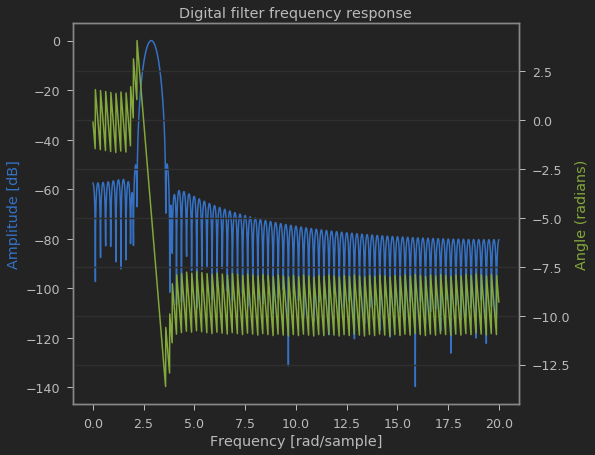

In [65]:
# Build an FIR filter for each channel's RF
freq_hz_half = 20000000
center_freq = 2880000
apass = 288000
blocklen = 65536

ac3_filt = sps.firwin(161,
            [
                (center_freq - apass) / freq_hz_half,
                (center_freq + apass) / freq_hz_half,
            ], 
            pass_zero=False)


ac3_fir = utils.filtfft([ac3_filt, 1.0], blocklen)

plotfilter(ac3_filt, [1.0])

In [99]:
fftp = utils.StridedCollector(cut_begin=1536, cut_end=512)
fftp.add(tbcrf)

output = []

pdata = fftp.get_block()
while pdata is not None:
    #print(len(pdata))
    fdata = np.fft.fft(pdata)
    odata = fftp.cut(np.fft.ifft(fdata * ac3_fir).real)
    odata = np.int8(odata / 16)
    output.append(odata)
    
    pdata = fftp.get_block()
    
    #break


In [101]:
ofd = open('test.filt', 'wb')
for o in output:
    ofd.write(o)

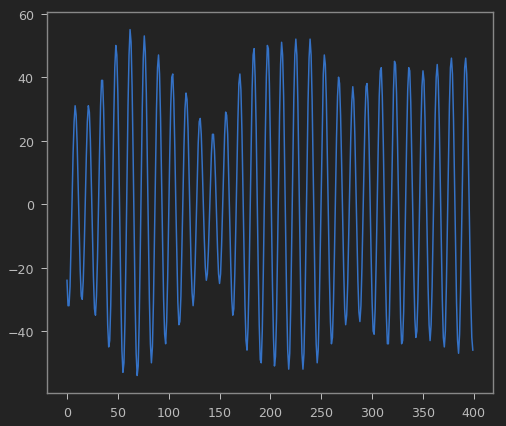

In [97]:
#plt.plot(pdata[0:1000])
plt.plot(odata[:400])

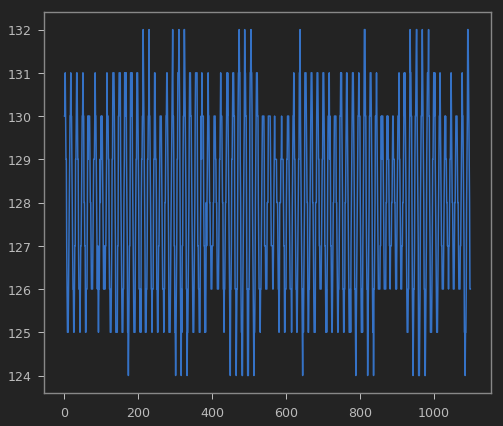

In [88]:
plt.plot(sox[0:1100])